In [101]:
# Imports

import gym
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import collections
import pandas as pd

In [105]:
# Hardcoded values
SARS_CURR_STATE_INDEX = 0
SARS_ACTION_INDEX = 1
SARS_REWARD_INDEX = 2
SARS_NEXT_STATE_INDEX = 3
SARS_IS_DONE_INDEX = 4

RUNNING_AVG_COUNT = 100

REWARD = "Reward"
ITERATION_NUMBER = "Iteration Number"
TRAINING = "Training"
TESTING = "Testing"

In [109]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_one_size, layer_two_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, layer_one_size)
        self.layer2 = nn.Linear(layer_one_size, layer_two_size)
        self.layer3 = nn.Linear(layer_two_size, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        return self.layer3(x)

def find_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    return device

def build_nn():
    device = find_device()
    return NeuralNetwork(8, 64, 64, 4).to(device)

In [110]:
class DQN_Agent:
    def __init__(self, alpha = .0001, epsilon = .99, epsilon_decay = .992, gamma = .99, sample_size = 200, c = 4):
        self.env = gym.make('LunarLander-v2').env

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = .01
        self.gamma = gamma

        self.replay_buffer = collections.deque([], maxlen=50000)
        self.nn = build_nn()
        self.optimizer = torch.optim.AdamW(self.nn.parameters(), lr=alpha)
        self.loss_fn = nn.SmoothL1Loss()

        self.target_nn = build_nn()
        self.target_nn.load_state_dict(self.nn.state_dict())

        self.sample_size = sample_size
        self.steps = 0
        self.C = c

        self.training_run_count = 500
        self.episode_time = 1000
        self.test_run_count = 100

    def run_lunar_lander(self):
        train_rewards = self.run_loop(is_training=True)
        test_rewards = self.run_loop(is_training=False)
        return train_rewards, test_rewards

    def run_loop(self, is_training):
        reward_list = []
        run_count = self.get_run_count(is_training)
        for run in range(run_count):
            reward = self.run_episode(is_training)
            reward_list.append(reward)
        return reward_list

    def get_run_count(self, is_training):
        if is_training:
            return self.training_run_count
        else:
            return self.test_run_count

    def run_episode(self, is_training):
        cum_reward, curr_state = 0, self.env.reset()
        for j in range(self.episode_time):
            sars_tuple = self.create_sars_tuple(curr_state)
            cum_reward += sars_tuple[SARS_REWARD_INDEX]

            if is_training: self.train_agent(sars_tuple)

            if sars_tuple[SARS_IS_DONE_INDEX]: break

            curr_state = sars_tuple[SARS_NEXT_STATE_INDEX]
        return cum_reward

    def create_sars_tuple(self, curr_state):
        curr_action = self.find_action(curr_state, self.epsilon)
        next_state, next_state_reward, is_done = self.get_state_and_reward(curr_action)
        return [curr_state, curr_action, next_state_reward, next_state, is_done]

    def find_action(self, state, epsilon):
        is_random = np.random.random() < epsilon
        if is_random:
            action = np.random.randint(4)
        else:
            action = self.get_action_with_torch(state)
        return action

    def get_action_with_torch(self, state):
        with torch.no_grad():
            return torch.argmax(self.nn(torch.from_numpy(state))).item()

    def get_state_and_reward(self, action):
        next_state = self.env.step(action)
        return next_state[0], next_state[1], next_state[2]

    def train_agent(self, sars_tuple):
        self.replay_buffer.append(sars_tuple)
        if len(self.replay_buffer) >= self.sample_size:
            self.q_learning()

    def q_learning(self):
        self.steps = self.steps + 1
        curr_state, curr_action, curr_reward, next_state, is_done = self.sample_replay_buffer()

        Q_expected = self.calculate_q_expected(curr_state, curr_action)
        Q_target  = self.calculate_q_target(next_state, curr_reward)

        self.update_optimizer(Q_expected, Q_target)
        self.update_target_nn()

    def sample_replay_buffer(self):
        sample_transitions_indices = np.random.choice(len(self.replay_buffer), self.sample_size, True)
        sample_transitions = np.array(self.replay_buffer, dtype=object)[sample_transitions_indices]
        curr_state, curr_action, curr_reward, next_state, is_done = unpack_experiences_array(sample_transitions)
        return curr_state, curr_action, curr_reward, next_state, is_done

    def calculate_q_expected(self, curr_state, curr_action):
        curr_state_rewards = self.nn(torch.from_numpy(curr_state))
        q_expected = curr_state_rewards[torch.arange(len(curr_state_rewards)), torch.from_numpy(curr_action)]
        return q_expected

    def calculate_q_target(self, next_state, curr_reward):
        with torch.no_grad():
            predictions = self.target_nn(torch.from_numpy(next_state))
            predicted_action = torch.argmax(predictions, 1)
            reward_of_action = predictions[torch.arange(len(predicted_action)), predicted_action]
            q_target = torch.from_numpy(curr_reward) + self.gamma * reward_of_action
        return q_target

    def update_optimizer(self, Q_expected, Q_target):
        loss = self.loss_fn(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_nn(self):
        if self.steps % self.C == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())

def print_update(reward_list):
    run_count = len(reward_list)
    if run_count % RUNNING_AVG_COUNT == 0:
        avg = last_100_runs_average(reward_list)
        print(f"average of last 100 runs is {avg}")

def last_100_runs_average(reward_list):
    array = np.array(reward_list)
    avg = np.average(array[-RUNNING_AVG_COUNT:])
    return avg

def unpack_experiences_array(experiences):
    current_state = np.stack(experiences[:, SARS_CURR_STATE_INDEX])
    action = np.array(experiences[:, SARS_ACTION_INDEX], dtype=int)
    rewards = np.array(experiences[:, SARS_REWARD_INDEX], dtype=float)
    next_state = np.stack(experiences[:, SARS_NEXT_STATE_INDEX])
    is_done = np.array(experiences[:, SARS_IS_DONE_INDEX], dtype=int)
    return current_state, action, rewards, next_state, is_done

In [ ]:
def run():
    agent = DQN_Agent()
    training_reward_list, test_reward_list = agent.run_lunar_lander()
    generate_all_plots(training_reward_list, test_reward_list)
    return training_reward_list, test_reward_list

def generate_all_plots(training_reward_list, test_reward_list):
    running_avg = running_mean(training_reward_list)
    generate_plot(training_reward_list, TRAINING)
    plt.plot(range(RUNNING_AVG_COUNT, len(training_reward_list) + 1), running_avg, label="100 run moving average reward")
    plt.legend()
    generate_plot(test_reward_list, TESTING)

def generate_plot(data, run_type):
    plt.figure(figsize=(12,8))
    plt.plot(data, label=f"{run_type} reward")
    plt.title(f"Reward during {run_type.lower()} by iteration")
    plt.ylabel(REWARD)
    plt.xlabel(ITERATION_NUMBER)
    plt.legend()

def running_mean(x):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[RUNNING_AVG_COUNT:] - cumsum[:-RUNNING_AVG_COUNT]) / float(RUNNING_AVG_COUNT)

run()

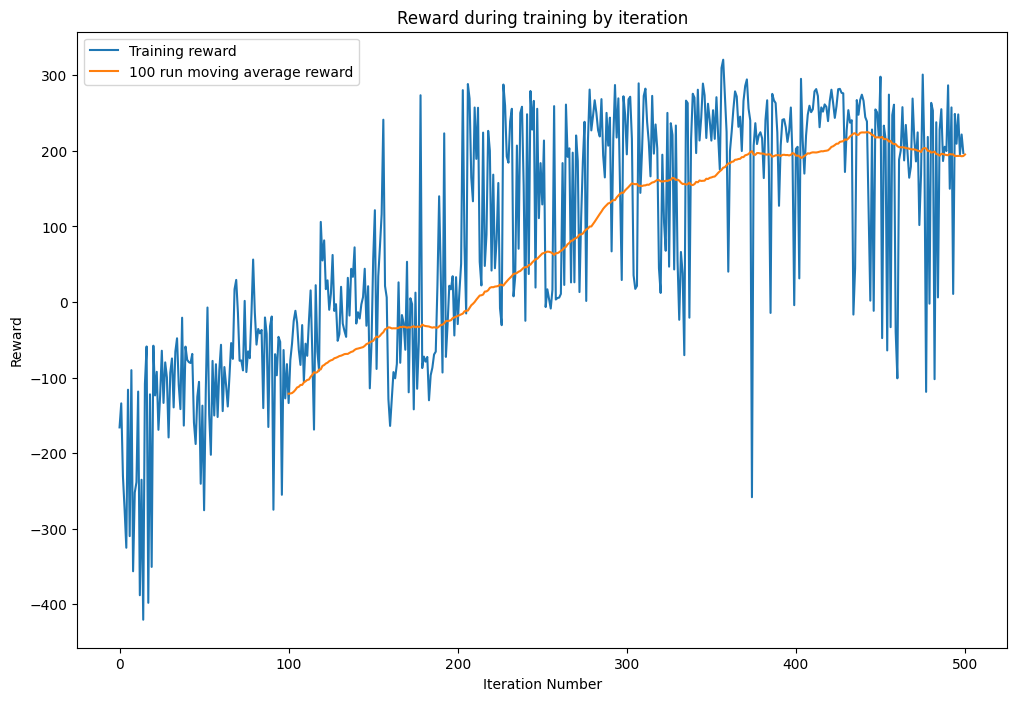

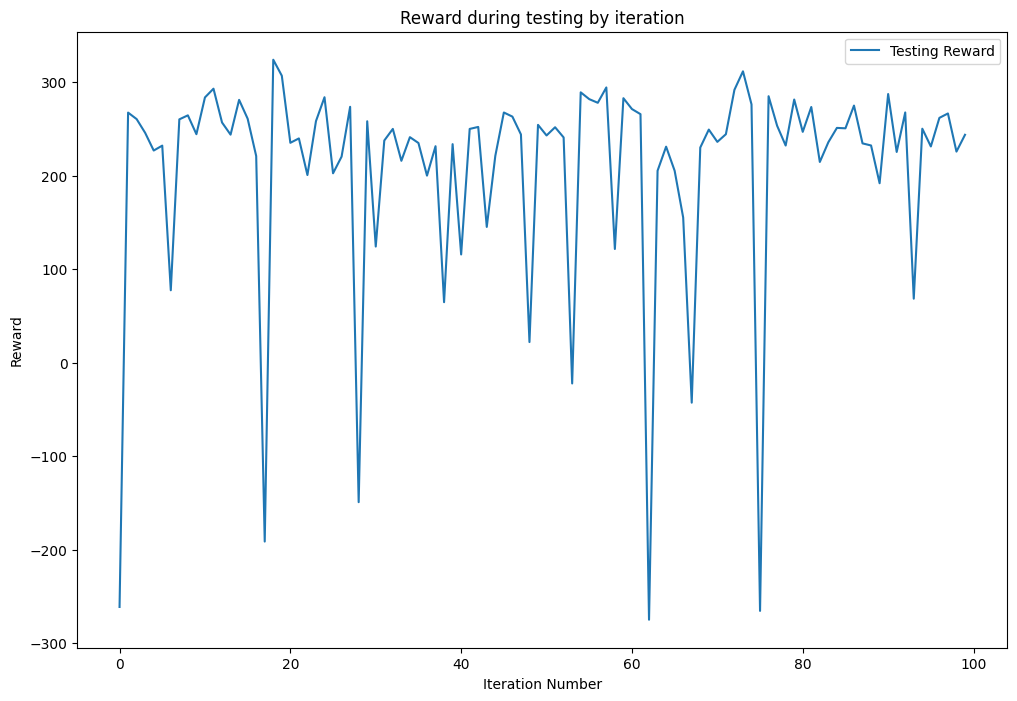